In [0]:
'''
The IPL Data Analysis project, using PySpark and Databricks, focuses on analyzing IPL match data, likely sourced from CSV files in an Amazon S3 bucket. The project involves data ingestion, cleaning, and transforming raw data into a usable format for analysis.

Key achievements:

Data Processing: Aggregates match stats like runs, wickets, and team/player performance.
Analysis: Identifies trends such as win/loss ratios and top players/teams.
EDA & Visualizations: Highlights key trends and shifts across IPL seasons.
Scalability: Leverages PySpark to handle large datasets efficiently for complex calculations.
End Goal: Provides actionable insights for data-driven decisions in IPL strategies.
'''

Out[2]: '\nThe IPL Data Analysis project, using PySpark and Databricks, focuses on analyzing IPL match data, likely sourced from CSV files in an Amazon S3 bucket. The project involves data ingestion, cleaning, and transforming raw data into a usable format for analysis.\n\nKey achievements:\n\nData Processing: Aggregates match stats like runs, wickets, and team/player performance.\nAnalysis: Identifies trends such as win/loss ratios and top players/teams.\nEDA & Visualizations: Highlights key trends and shifts across IPL seasons.\nScalability: Leverages PySpark to handle large datasets efficiently for complex calculations.\nEnd Goal: Provides actionable insights for data-driven decisions in IPL strategies.\n'

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType, BooleanType 
from pyspark.sql.functions import sum, avg ,count ,col ,when
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [0]:
#creating a spark session 
spark = SparkSession.builder.appName("ipl_data_analysis_project").getOrCreate()

In [0]:

#Creating schema for deliveries.csv
delivery_schema = StructType([
    StructField("match_id", IntegerType(), True),
    StructField("inning", IntegerType(), True),
    StructField("batting_team", StringType(), True),
    StructField("bowling_team", StringType(), True),
    StructField("over", IntegerType(), True),
    StructField("ball", IntegerType(), True),
    StructField("batter", StringType(), True),
    StructField("bowler", StringType(), True),
    StructField("non_striker", StringType(), True),
    StructField("batsman_runs", IntegerType(), True),
    StructField("extra_runs", IntegerType(), True),
    StructField("total_runs", IntegerType(), True),
    StructField("extras_type", StringType(), True),
    StructField("is_wicket", IntegerType(), True),
    StructField("player_dismissed", StringType(), True),
    StructField("dismissal_kind", StringType(), True),
    StructField("fielder", StringType(), True)
])


In [0]:
#loading data into datafame
deliver_df = spark.read.schema(delivery_schema).format("csv").option("header","true").load("s3://ipl-raw-data-bucket/archive/deliveries.csv")

In [0]:
#Viewing Sample data
deliver_df.show(5)

+--------+------+--------------------+--------------------+----+----+-----------+-------+-----------+------------+----------+----------+-----------+---------+----------------+--------------+-------+
|match_id|inning|        batting_team|        bowling_team|over|ball|     batter| bowler|non_striker|batsman_runs|extra_runs|total_runs|extras_type|is_wicket|player_dismissed|dismissal_kind|fielder|
+--------+------+--------------------+--------------------+----+----+-----------+-------+-----------+------------+----------+----------+-----------+---------+----------------+--------------+-------+
|  335982|     1|Kolkata Knight Ri...|Royal Challengers...|   0|   1| SC Ganguly|P Kumar|BB McCullum|           0|         1|         1|    legbyes|        0|              NA|            NA|     NA|
|  335982|     1|Kolkata Knight Ri...|Royal Challengers...|   0|   2|BB McCullum|P Kumar| SC Ganguly|           0|         0|         0|       null|        0|              NA|            NA|     NA|
|  33

In [0]:
#Creating schema for matches.csv

match_schema= StructType([
    StructField("id", IntegerType(), True),
    StructField("season", StringType(), True),
    StructField("city", StringType(), True),
    StructField("date", DateType(), True),
    StructField("match_type", StringType(), True),
    StructField("player_of_match", StringType(), True),
    StructField("venue", StringType(), True),
    StructField("team1", StringType(), True),
    StructField("team2", StringType(), True),
    StructField("toss_winner", StringType(), True),
    StructField("toss_decision", StringType(), True),
    StructField("winner", StringType(), True),
    StructField("result", StringType(), True),
    StructField("result_margin", StringType(), True),
    StructField("target_runs", IntegerType(), True),
    StructField("target_overs", IntegerType(), True),
    StructField("super_over", StringType(), True),
    StructField("method", StringType(), True),
    StructField("umpire1", StringType(), True),
    StructField("umpire2", StringType(), True)
])



In [0]:
#loaading data into matches_df dataframe
matches_df = spark.read.schema(match_schema).format("csv").option("header","true").load("s3://ipl-raw-data-bucket/archive/matches.csv")

In [0]:
matches_df.show(5)

+------+-------+----------+----------+----------+---------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+-----------+------------+----------+------+---------+--------------+
|    id| season|      city|      date|match_type|player_of_match|               venue|               team1|               team2|         toss_winner|toss_decision|              winner| result|result_margin|target_runs|target_overs|super_over|method|  umpire1|       umpire2|
+------+-------+----------+----------+----------+---------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+-----------+------------+----------+------+---------+--------------+
|335982|2007/08| Bangalore|2008-04-18|    League|    BB McCullum|M Chinnaswamy Sta...|Royal Challengers...|Kolkata Knight Ri...|Royal Challengers...|        field|Kolkata Knig

In [0]:
# Transforming data nad adding column to deliver df
window_spex = Window.partitionBy('match_id','inning').orderBy('over','ball')

deliver_df = deliver_df.withColumn(
    'running_total',sum('total_runs').over(window_spex))

In [0]:
# reviwing sample data 
deliver_df.show(5)

+--------+------+-------------------+---------------+----+----+---------+------+-----------+------------+----------+----------+-----------+---------+----------------+--------------+-------+-------------+
|match_id|inning|       batting_team|   bowling_team|over|ball|   batter|bowler|non_striker|batsman_runs|extra_runs|total_runs|extras_type|is_wicket|player_dismissed|dismissal_kind|fielder|running_total|
+--------+------+-------------------+---------------+----+----+---------+------+-----------+------------+----------+----------+-----------+---------+----------------+--------------+-------+-------------+
|  335983|     1|Chennai Super Kings|Kings XI Punjab|   0|   1| PA Patel| B Lee|  ML Hayden|           0|         0|         0|       null|        0|              NA|            NA|     NA|            0|
|  335983|     1|Chennai Super Kings|Kings XI Punjab|   0|   2| PA Patel| B Lee|  ML Hayden|           0|         0|         0|       null|        0|              NA|            NA|   

In [0]:
# finding the total and average runs scored in each match

total_avg = deliver_df.groupBy('match_id','inning',).agg(
    sum("total_runs").alias("Runs_scored"),
    avg("total_runs").alias("Average_runs_per_ball"),
    count('ball').alias('balls_per_inings')
)

total_avg.show(5)

+--------+------+-----------+---------------------+----------------+
|match_id|inning|Runs_scored|Average_runs_per_ball|balls_per_inings|
+--------+------+-----------+---------------------+----------------+
|  336009|     1|        187|   1.4841269841269842|             126|
|  392196|     1|        165|   1.2992125984251968|             127|
|  419132|     1|        163|   1.2834645669291338|             127|
|  392196|     2|        169|    1.396694214876033|             121|
|  335993|     1|        147|   1.1666666666666667|             126|
+--------+------+-----------+---------------------+----------------+
only showing top 5 rows



In [0]:
#Now highlighting the impact balls i.e 6+,wickets
# adding impact ball column to deliver df

deliver_df = deliver_df.withColumn(
    "IMPACT_BOWL",
    when((col('total_runs') + col('extra_runs') > 6) | (col('is_wicket') == True), True).otherwise(False)
)


In [0]:
deliver_df.show(5)

+--------+------+-------------------+---------------+----+----+---------+------+-----------+------------+----------+----------+-----------+---------+----------------+--------------+-------+-------------+-----------+
|match_id|inning|       batting_team|   bowling_team|over|ball|   batter|bowler|non_striker|batsman_runs|extra_runs|total_runs|extras_type|is_wicket|player_dismissed|dismissal_kind|fielder|running_total|IMPACT_BOWL|
+--------+------+-------------------+---------------+----+----+---------+------+-----------+------------+----------+----------+-----------+---------+----------------+--------------+-------+-------------+-----------+
|  335983|     1|Chennai Super Kings|Kings XI Punjab|   0|   1| PA Patel| B Lee|  ML Hayden|           0|         0|         0|       null|        0|              NA|            NA|     NA|            0|      false|
|  335983|     1|Chennai Super Kings|Kings XI Punjab|   0|   2| PA Patel| B Lee|  ML Hayden|           0|         0|         0|       nu

In [0]:
# classifiing wins as high medium and low margin wins
# based on runs(100+,50-99,0-49) and wicketes(8+,5-7,0-4)

# adding result margin column to matches df

matches_df = matches_df.withColumn(
    'win_margin_category',
    when((col("result") == 'runs') & (col('result_margin') >= 100), "high")
    .when((col("result") == 'runs') & (col('result_margin') >= 50) & (col('result_margin') < 100), 'medium')
    .when((col("result") == 'runs') & (col('result_margin') < 50), 'low')
    .when((col("result") == 'wickets') & (col('result_margin') >= 8), 'high')
    .when((col("result") == 'wickets') & (col('result_margin') >= 5) & (col('result_margin') < 8), 'medium')
    .when((col("result") == 'wickets') & (col('result_margin') < 5) & (col('result_margin') >= 0), 'low')
    .otherwise("unknown")
)



In [0]:
# reviewing sample data
matches_df.show(5)


+------+-------+----------+----------+----------+---------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+-----------+------------+----------+------+---------+--------------+-------------------+
|    id| season|      city|      date|match_type|player_of_match|               venue|               team1|               team2|         toss_winner|toss_decision|              winner| result|result_margin|target_runs|target_overs|super_over|method|  umpire1|       umpire2|win_margin_category|
+------+-------+----------+----------+----------+---------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+-------------+-----------+------------+----------+------+---------+--------------+-------------------+
|335982|2007/08| Bangalore|2008-04-18|    League|    BB McCullum|M Chinnaswamy Sta...|Royal Challengers...|Kolkata 

In [0]:
#Adiing toss_match _winner column to matches df

matches_df = matches_df.withColumn(
    "toss_match_winner",
    when((col('toss_winner') == col('winner')), True).otherwise(False)
)

In [0]:
# reviewing both dataframe for reciding data

matches_df.show(2)
deliver_df.show(2)

+------+-------+----------+----------+----------+---------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+------+-------------+-----------+------------+----------+------+---------+-----------+-------------------+-----------------+
|    id| season|      city|      date|match_type|player_of_match|               venue|               team1|               team2|         toss_winner|toss_decision|              winner|result|result_margin|target_runs|target_overs|super_over|method|  umpire1|    umpire2|win_margin_category|toss_match_winner|
+------+-------+----------+----------+----------+---------------+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+------+-------------+-----------+------------+----------+------+---------+-----------+-------------------+-----------------+
|335982|2007/08| Bangalore|2008-04-18|    League|    BB McCullum|M Chinna

In [0]:
# Creating global temp view for running sql quiries 

deliver_df.createOrReplaceTempView("deliveries")
matches_df.createOrReplaceTempView("matches")

In [0]:
#SQL query to show  top scoring batsman in IPL
query=''' 
SELECT d.batter as BATSMAN,sum(d.batsman_runs) AS RUNS_SCORED,m.season as SEASON
FROM deliveries d
JOIN matches m ON d.match_id=m.id
GROUP BY d.batter,m.season
ORDER BY RUNS_SCORED DESC
'''

top_score_batsman=spark.sql(query)
top_score_batsman.show(5)

+------------+-----------+------+
|     BATSMAN|RUNS_SCORED|SEASON|
+------------+-----------+------+
|     V Kohli|        973|  2016|
|Shubman Gill|        890|  2023|
|  JC Buttler|        863|  2022|
|   DA Warner|        848|  2016|
|     V Kohli|        741|  2024|
+------------+-----------+------+
only showing top 5 rows



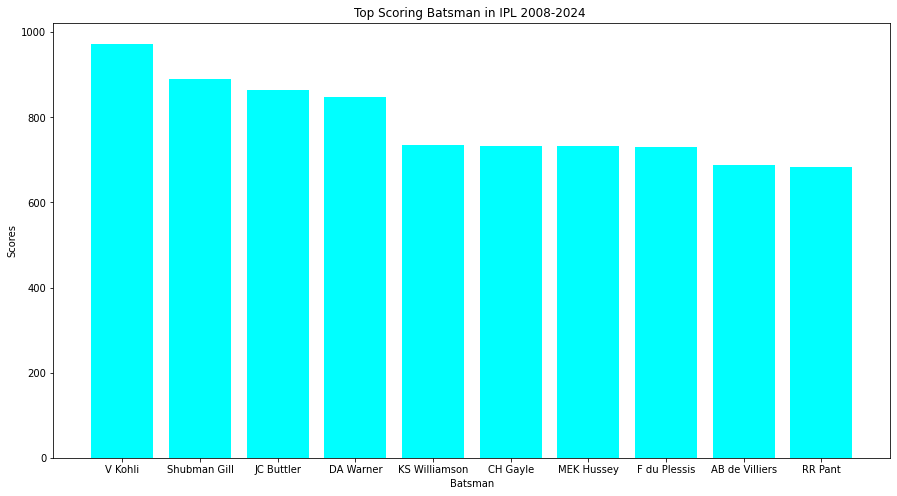

In [0]:
# plotting graph for top scoring batsmann to gain insights

# Convert to Pandas DataFrame
top_score_batsman_pd=top_score_batsman.toPandas()

# Remove duplicates based on 'BATSMAN' and Limiting to top 10 for clarity in the plot
top_score_batsman_pd=top_score_batsman_pd.drop_duplicates(subset=['BATSMAN']).nlargest(10, 'RUNS_SCORED')

plt.figure(figsize=(15,8))
plt.bar(top_score_batsman_pd['BATSMAN'], top_score_batsman_pd['RUNS_SCORED'], color='cyan')
plt.xlabel("Batsman")
plt.ylabel("Scores")
plt.title("Top Scoring Batsman in IPL 2008-2024 ")
plt.show()

In [0]:
#SQL query to show most economical bowler in terms of avg runs given

query=''' 
SELECT d.bowler as BOWLER,avg(d.total_runs) AS RUNS_GIVEN_PER_BALL ,m.season as SEASON,sum(d.total_runs)
,count(d.ball)
FROM deliveries d
JOIN matches m ON d.match_id=m.id
GROUP BY d.bowler,m.season
HAVING COUNT(*) >180
ORDER BY RUNS_GIVEN_PER_BALL,m.season
'''

most_eco_bowler=spark.sql(query)
most_eco_bowler.show(5)
most_eco_bowler.count()

+--------------+-------------------+-------+---------------+-----------+
|        BOWLER|RUNS_GIVEN_PER_BALL| SEASON|sum(total_runs)|count(ball)|
+--------------+-------------------+-------+---------------+-----------+
|M Muralitharan| 0.8782894736842105|   2009|            267|        304|
|      L Balaji| 0.8941798941798942|   2012|            169|        189|
|   Rashid Khan|  0.907928388746803|2020/21|            355|        391|
|     SP Narine| 0.9121447028423773|   2013|            353|        387|
|      R Sharma| 0.9205298013245033|   2011|            278|        302|
+--------------+-------------------+-------+---------------+-----------+
only showing top 5 rows

Out[23]: 612

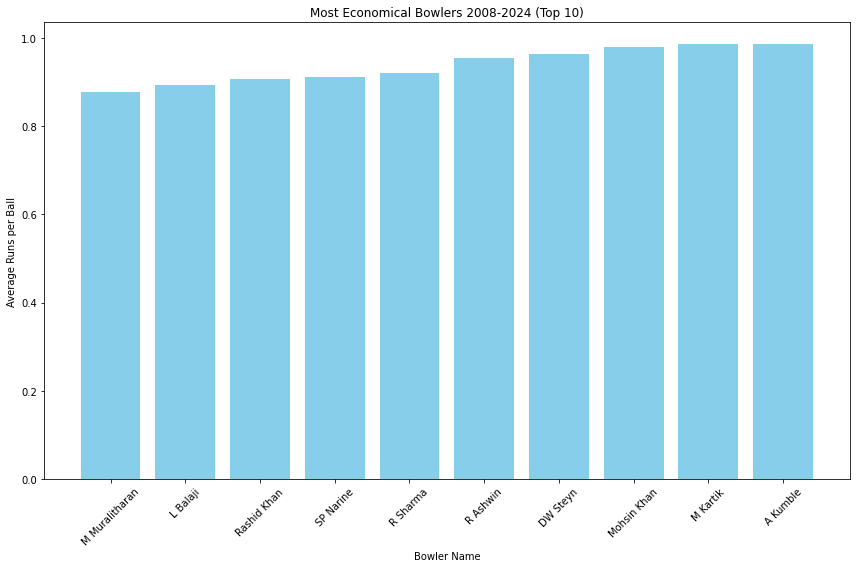

In [0]:
#Plotting graph for most economical bowle in terms of avg runs given in IPL

# Convert to Pandas DataFrame
economical_bowlers_pd = most_eco_bowler.toPandas()

plt.figure(figsize=(12,8))
# Remove duplicates based on 'BOWLER' and Limiting to top 10 for clarity in the plot
top_economical_bowlers = economical_bowlers_pd.drop_duplicates(subset=['BOWLER']).nsmallest(10, 'RUNS_GIVEN_PER_BALL')


plt.bar(top_economical_bowlers['BOWLER'], top_economical_bowlers['RUNS_GIVEN_PER_BALL'], color='skyblue')
plt.xlabel('Bowler Name')
plt.ylabel('Average Runs per Ball')
plt.title('Most Economical Bowlers 2008-2024 (Top 10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [0]:
#SQL query to show most economical bowler in power play IPL

query=''' 
SELECT d.bowler as BOWLER,avg(d.total_runs) AS RUNS_GIVEN_PER_BALL ,m.season as SEASON,sum(d.total_runs)
,count(d.ball)
FROM deliveries d
JOIN matches m ON d.match_id=m.id
WHERE d.over <= 4
GROUP BY d.bowler,m.season
HAVING COUNT(*) >180
ORDER BY RUNS_GIVEN_PER_BALL,m.season
'''

most_eco_bowler_pp=spark.sql(query)
most_eco_bowler_pp.show(5)
most_eco_bowler_pp.count()

+----------+-------------------+-------+---------------+-----------+
|    BOWLER|RUNS_GIVEN_PER_BALL| SEASON|sum(total_runs)|count(ball)|
+----------+-------------------+-------+---------------+-----------+
|  DW Steyn| 0.8387096774193549|   2013|            182|        217|
|   B Kumar| 0.8852459016393442|   2013|            162|        183|
|   P Kumar|  0.957345971563981|   2013|            202|        211|
|GD McGrath| 0.9646017699115044|2007/08|            218|        226|
|   B Kumar| 0.9819819819819819|   2016|            218|        222|
+----------+-------------------+-------+---------------+-----------+
only showing top 5 rows

Out[25]: 41

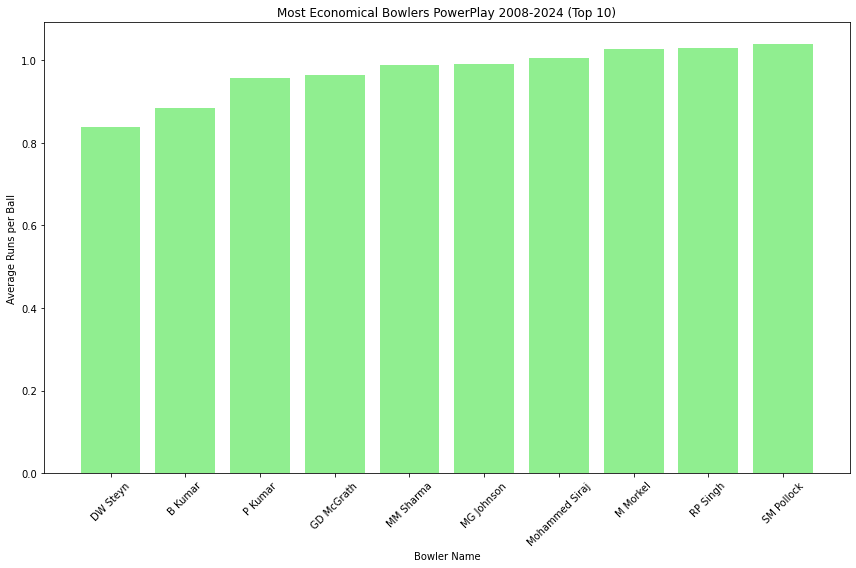

In [0]:


# Convert to Pandas DataFrame
economical_bowlers_pp_pd = most_eco_bowler_pp.toPandas()

# Remove duplicates based on 'BOWLER' and Limiting to top 10 for clarity in the plot
top_economical_bowlers_pp = economical_bowlers_pp_pd.drop_duplicates(subset=['BOWLER']).nsmallest(10, 'RUNS_GIVEN_PER_BALL')

# Plotting the data
plt.figure(figsize=(12,8))
plt.bar(top_economical_bowlers_pp['BOWLER'], top_economical_bowlers_pp['RUNS_GIVEN_PER_BALL'], color='lightgreen')
plt.xlabel('Bowler Name')
plt.ylabel('Average Runs per Ball')
plt.title('Most Economical Bowlers PowerPlay 2008-2024 (Top 10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [0]:
#SQL query to show most wicket taking bowler per season
query = ''' 
SELECT d.bowler as BOWLER, SUM(d.is_wicket) AS WICKETS_TAKEN, m.season as SEASON
FROM deliveries d
JOIN matches m ON d.match_id = m.id
GROUP BY d.bowler, m.season
ORDER BY WICKETS_TAKEN DESC,m.season
'''

most_wicket_taking_bowler = spark.sql(query)
most_wicket_taking_bowler.show(5)
most_wicket_taking_bowler.count()


+-----------+-------------+-------+
|     BOWLER|WICKETS_TAKEN| SEASON|
+-----------+-------------+-------+
|   HV Patel|           35|   2021|
|   DJ Bravo|           34|   2013|
|JP Faulkner|           33|   2013|
|   K Rabada|           32|2020/21|
|  MM Sharma|           31|   2023|
+-----------+-------------+-------+
only showing top 5 rows

Out[27]: 1948

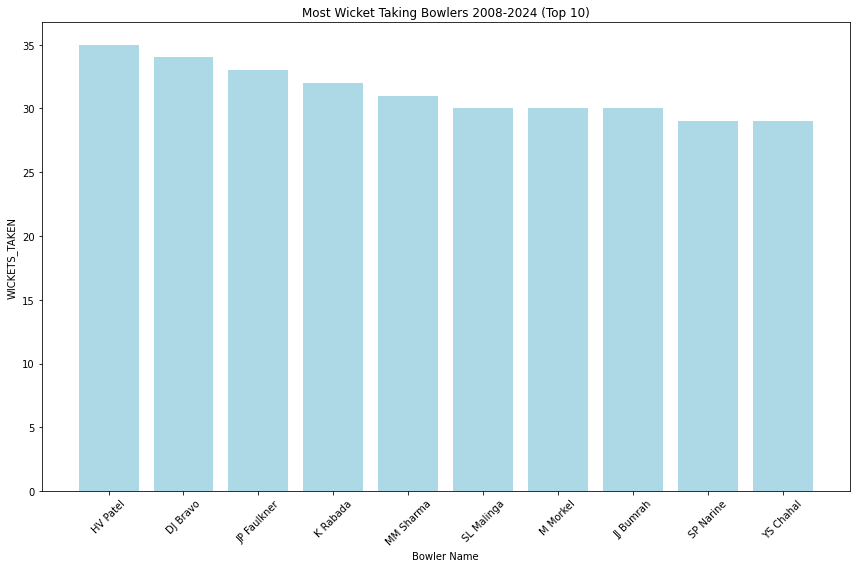

In [0]:

# Convert to Pandas DataFrame
most_wicket_taking_pd = most_wicket_taking_bowler.toPandas()

plt.figure(figsize=(12,8))
# Remove duplicates based on 'BOWLER' and Limiting to top 10 for clarity in the plot
most_wicket_taking= most_wicket_taking_pd.drop_duplicates(subset=['BOWLER']).nlargest(10, 'WICKETS_TAKEN')



plt.bar(most_wicket_taking['BOWLER'], most_wicket_taking['WICKETS_TAKEN'], color='lightblue')
plt.xlabel('Bowler Name')
plt.ylabel('WICKETS_TAKEN')
plt.title('Most Wicket Taking Bowlers 2008-2024 (Top 10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [0]:
#SQL query to show most sixes by batsmann
query = ''' 
SELECT d.batter as BATSMAN, COUNT(d.batsman_runs) AS NO_OF_SIXES, m.season as SEASON
FROM deliveries d
JOIN matches m ON d.match_id = m.id
WHERE d.batsman_runs = 6
GROUP BY m.season ,d.batter
ORDER BY NO_OF_SIXES DESC,m.season

'''

most_sixes_batsman = spark.sql(query)
most_sixes_batsman.show(5)
most_sixes_batsman.count()


+----------+-----------+------+
|   BATSMAN|NO_OF_SIXES|SEASON|
+----------+-----------+------+
|  CH Gayle|         59|  2012|
|  CH Gayle|         52|  2013|
|AD Russell|         52|  2019|
|JC Buttler|         45|  2022|
|  CH Gayle|         44|  2011|
+----------+-----------+------+
only showing top 5 rows

Out[29]: 1628

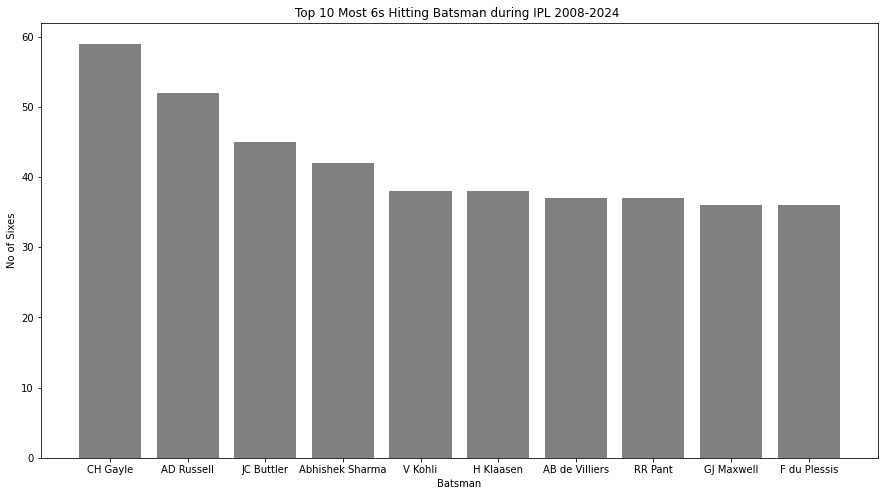

In [0]:
# Convert to Pandas DataFrame
most_sixes_batsman_pd=most_sixes_batsman.toPandas()

# Remove duplicates based on 'BATSMAN' and Limiting to top 10 for clarity in the plot
most_sixes_batsman_pd=most_sixes_batsman_pd.drop_duplicates(subset=['BATSMAN']).nlargest(10, 'NO_OF_SIXES')

plt.figure(figsize=(15,8))
plt.bar(most_sixes_batsman_pd['BATSMAN'], most_sixes_batsman_pd['NO_OF_SIXES'], color='grey')
plt.xlabel("Batsman")
plt.ylabel("No of Sixes")
plt.title("Top 10 Most 6s Hitting Batsman during IPL 2008-2024 ")
plt.show()

In [0]:
#SQL query to show most foures
query = ''' 
SELECT d.batter as BATSMAN, COUNT(d.batsman_runs) AS NO_OF_FOURS, m.season as SEASON
FROM deliveries d
JOIN matches m ON d.match_id = m.id
WHERE d.batsman_runs = 4
GROUP BY m.season ,d.batter
ORDER BY NO_OF_FOURS DESC,m.season

'''

most_fours_batsman = spark.sql(query)
most_fours_batsman.show(5)
most_fours_batsman.count()

+------------+-----------+-------+
|     BATSMAN|NO_OF_FOURS| SEASON|
+------------+-----------+-------+
|   DA Warner|         88|   2016|
|SR Tendulkar|         86|2009/10|
|Shubman Gill|         85|   2023|
|     V Kohli|         84|   2016|
|  JC Buttler|         84|   2022|
+------------+-----------+-------+
only showing top 5 rows

Out[31]: 1968

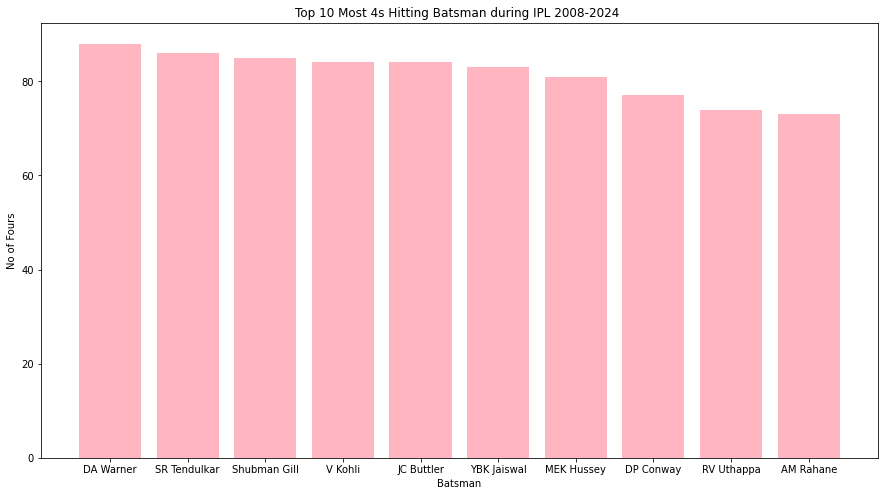

In [0]:
# Convert to Pandas DataFrame
most_fours_batsman_pd=most_fours_batsman.toPandas()

# Remove duplicates based on 'BATSMAN' and Limiting to top 10 for clarity in the plot
most_fours_batsman_pd=most_fours_batsman_pd.drop_duplicates(subset=['BATSMAN']).nlargest(10, 'NO_OF_FOURS')

plt.figure(figsize=(15,8))
plt.bar(most_fours_batsman_pd['BATSMAN'], most_fours_batsman_pd['NO_OF_FOURS'], color='lightpink')
plt.xlabel("Batsman")
plt.ylabel("No of Fours")
plt.title("Top 10 Most 4s Hitting Batsman during IPL 2008-2024 ")
plt.show()

In [0]:

# SQL query to show win/loss after winning toss
query='''
SELECT m.id, m.toss_winner, m.winner,m.toss_match_winner
FROM matches m
ORDER BY m.id
'''
toss_impact_individual_matches = spark.sql(query)
toss_impact_individual_matches.show(5)
toss_impact_individual_matches.count()

+------+--------------------+--------------------+-----------------+
|    id|         toss_winner|              winner|toss_match_winner|
+------+--------------------+--------------------+-----------------+
|335982|Royal Challengers...|Kolkata Knight Ri...|            false|
|335983| Chennai Super Kings| Chennai Super Kings|             true|
|335984|    Rajasthan Royals|    Delhi Daredevils|            false|
|335985|      Mumbai Indians|Royal Challengers...|            false|
|335986|     Deccan Chargers|Kolkata Knight Ri...|            false|
+------+--------------------+--------------------+-----------------+
only showing top 5 rows

Out[33]: 1095

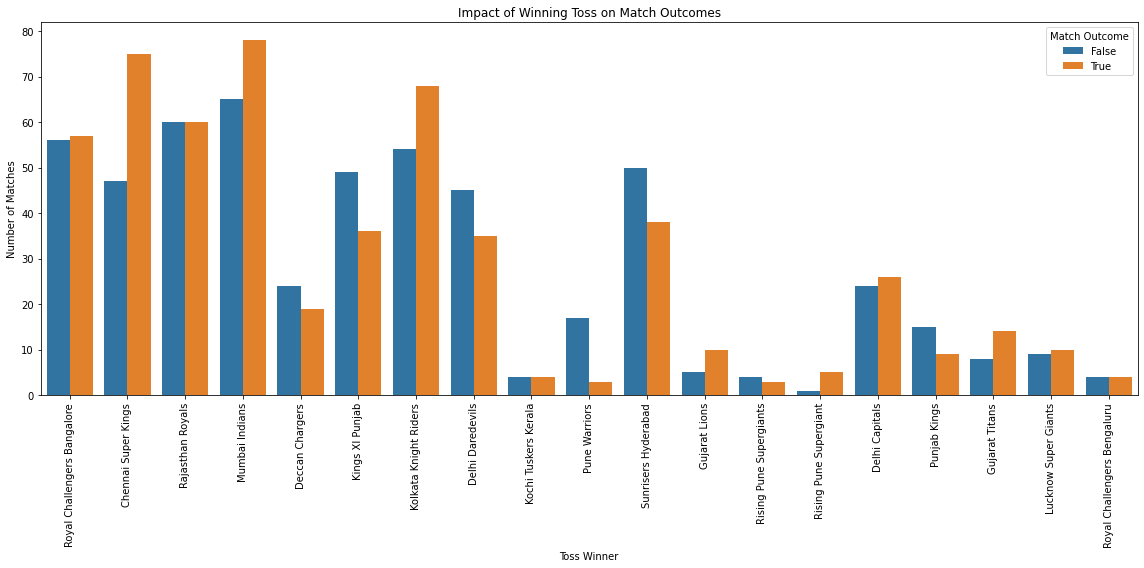

In [0]:
# Convert to Pandas DataFrame
toss_impact_pd = toss_impact_individual_matches.toPandas()

# Creating a countplot to show win/loss after winning toss
plt.figure(figsize=(16, 8))
sns.countplot(x='toss_winner', hue='toss_match_winner', data=toss_impact_pd)
plt.title('Impact of Winning Toss on Match Outcomes')
plt.xlabel('Toss Winner')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [0]:
# SQL query to get avg scores as per venue
query=''' SELECT AVG(RUNS_SCORED) AS AVG_SCORE,MAX(RUNS_SCORED) AS HIGHEST_SCORE,VENUE
FROM(
    SELECT SUM(d.total_runs) AS RUNS_SCORED ,m.venue AS VENUE
    FROM deliveries d
    JOIN matches m ON d.match_id = m.id
    GROUP BY VENUE,d.match_id
    ORDER BY RUNS_SCORED DESC
    )
GROUP BY VENUE
ORDER BY AVG_SCORE DESC
'''

avg_scores_venue=spark.sql(query)
avg_scores_venue.show(5)

+------------------+-------------+--------------------+
|         AVG_SCORE|HIGHEST_SCORE|               VENUE|
+------------------+-------------+--------------------+
|             400.0|          438|Dr. Y.S. Rajasekh...|
|          380.6875|          504|Arun Jaitley Stad...|
|          380.3125|          523|Eden Gardens, Kol...|
|380.14285714285717|          549|M Chinnaswamy Sta...|
|            378.75|          422|Himachal Pradesh ...|
+------------------+-------------+--------------------+
only showing top 5 rows



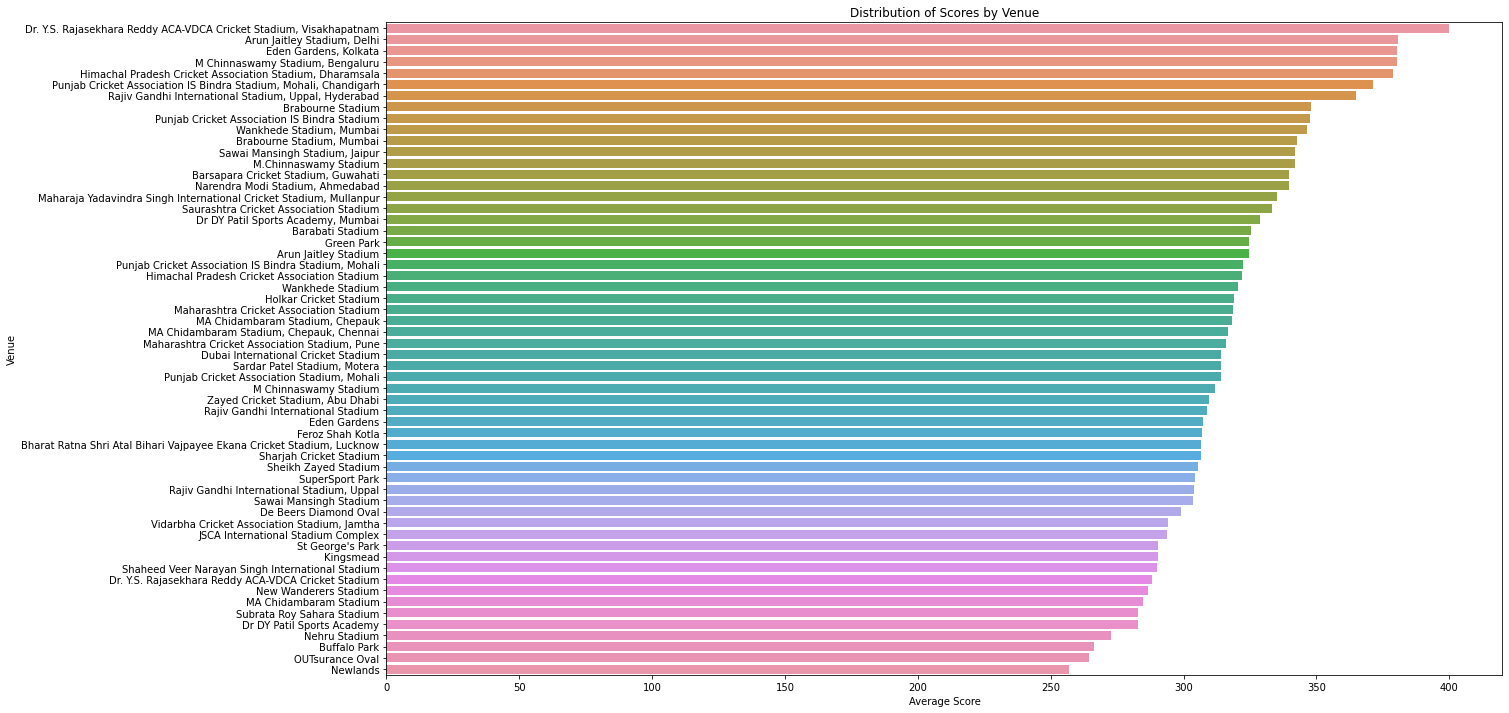

In [0]:

# Convert to Pandas DataFrame
avg_scores_venue_pd = avg_scores_venue.toPandas()

# Plot
plt.figure(figsize=(20, 12))
sns.barplot(x='AVG_SCORE', y='VENUE', data=avg_scores_venue_pd)
plt.title('Distribution of Scores by Venue')
plt.xlabel('Average Score')
plt.ylabel('Venue')
plt.show()

+-----------+--------------------+
|RUNS_SCORED|               VENUE|
+-----------+--------------------+
|        549|M Chinnaswamy Sta...|
|        523|Rajiv Gandhi Inte...|
|        523|Eden Gardens, Kol...|
|        504|Arun Jaitley Stad...|
|        469|MA Chidambaram St...|
+-----------+--------------------+
only showing top 5 rows

None


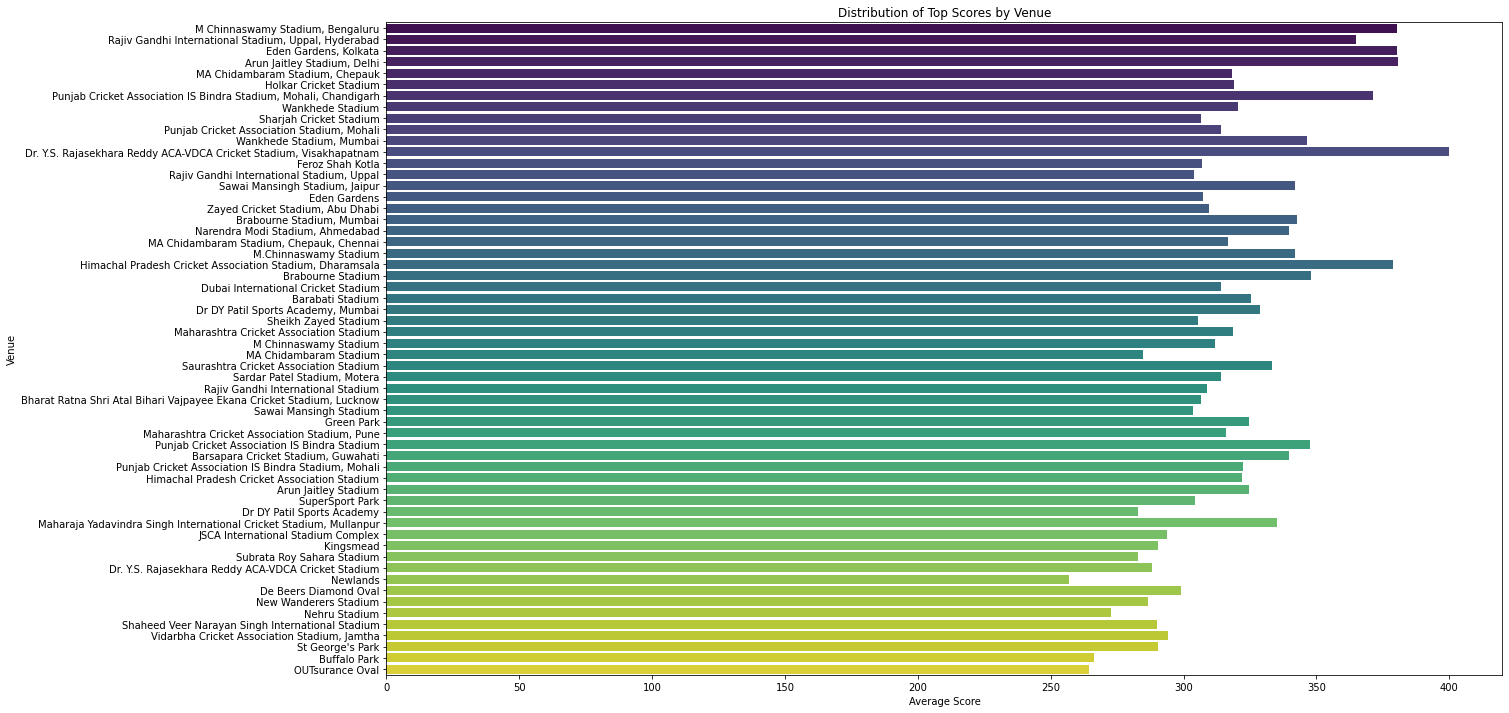

In [0]:
# SQL query to ge top scores as per venue
query='''
SELECT SUM(d.total_runs) AS RUNS_SCORED ,m.venue AS VENUE
FROM deliveries d
JOIN matches m ON d.match_id = m.id
GROUP BY m.venue,d.match_id
ORDER BY RUNS_SCORED DESC
'''
top_scores_venue=spark.sql(query)
print(top_scores_venue.show(5))

# Convert to Pandas DataFrame
top_scores_venue_pd = top_scores_venue.toPandas()

# Plot
plt.figure(figsize=(20, 12))
sns.barplot(x='RUNS_SCORED', y='VENUE', data=top_scores_venue_pd,ci=None,palette='viridis')
plt.title('Distribution of Top Scores by Venue')
plt.xlabel('Average Score')
plt.ylabel('Venue')
plt.show()

+-----------------+---------+
|         OUT_TYPE|FREQUENCY|
+-----------------+---------+
|           caught|     8063|
|           bowled|     2212|
|          run out|     1114|
|              lbw|      800|
|caught and bowled|      367|
+-----------------+---------+
only showing top 5 rows



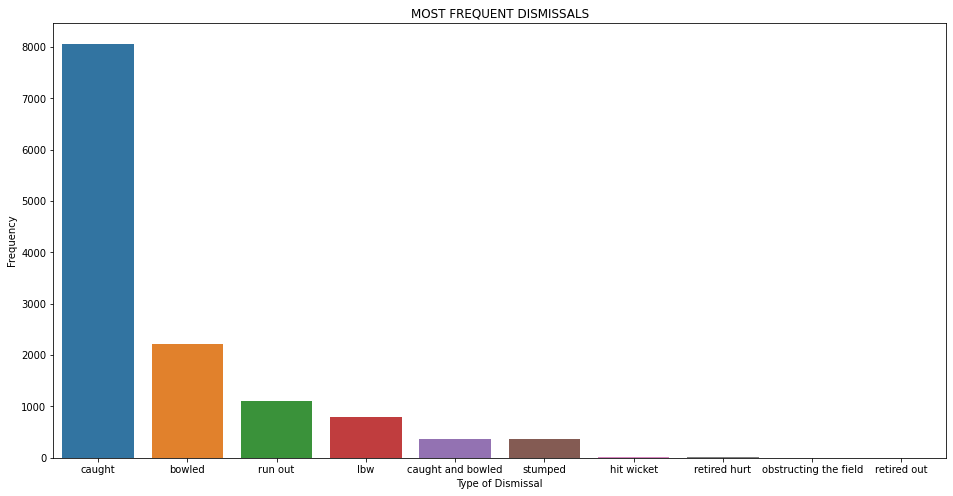

In [0]:


# Filter out NULL values in the 'dismissal_kind' column
deliveries_cleaned = deliver_df.filter(col("dismissal_kind")!='NA')

# Register the cleaned DataFrame as a temporary view
deliveries_cleaned.createOrReplaceTempView("deliveries_cleaned")

# SQL query to get dismissal kinds and their frequencies
query = '''
SELECT d.dismissal_kind AS OUT_TYPE, COUNT(*) AS FREQUENCY
FROM deliveries_cleaned d
GROUP BY d.dismissal_kind
ORDER BY FREQUENCY DESC
'''
types_of_dis = spark.sql(query)

# Show the top 5 rows
types_of_dis.show(5)



types_of_dis_pd = types_of_dis.toPandas()
# Remove duplicates based on 'OUT_TYPE'
types_of_dis_pd =types_of_dis_pd.drop_duplicates(subset=['OUT_TYPE'])
plt.figure(figsize=(16,8))
sns.barplot(x='OUT_TYPE',y='FREQUENCY',data=types_of_dis_pd,ci=None)
plt.title('MOST FREQUENT DISMISSALS')
plt.xlabel("Type of Dismissal")
plt.ylabel("Frequency")
plt.show()

+--------------------+-------------------+
|           TEAM_NAME|WINS_AFTER_TOSS_WON|
+--------------------+-------------------+
|Royal Challengers...|                 72|
|Kolkata Knight Ri...|                 70|
| Chennai Super Kings|                 67|
|      Mumbai Indians|                 65|
|    Rajasthan Royals|                 47|
+--------------------+-------------------+
only showing top 5 rows



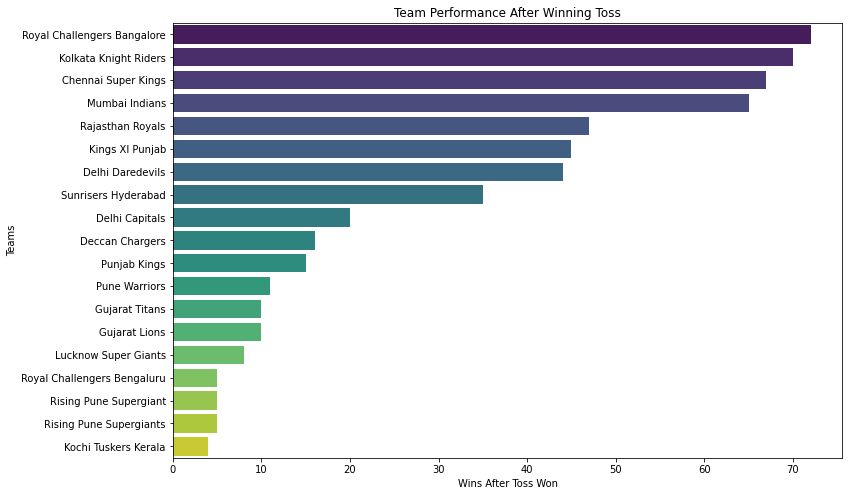

In [0]:
# team performance after winning toss
query='''
SELECT team1 AS TEAM_NAME,count(winner) AS WINS_AFTER_TOSS_WON
FROM matches
WHERE toss_winner = winner
GROUP BY TEAM_NAME
ORDER BY WINS_AFTER_TOSS_WON DESC
'''
toss_won_match_won=spark.sql(query)
toss_won_match_won.show(5)

toss_won_match_won_pd = toss_won_match_won.toPandas()

plt.figure(figsize=(12,8))
sns.barplot(x='WINS_AFTER_TOSS_WON', y='TEAM_NAME', data=toss_won_match_won_pd ,ci=None,palette='viridis')
plt.xlabel("Wins After Toss Won")
plt.ylabel("Teams")
plt.title("Team Performance After Winning Toss")
plt.show()


+--------------------+--------------------+
|           TEAM_NAME|WINS_AFTER_TOSS_LOST|
+--------------------+--------------------+
|Royal Challengers...|                  63|
| Chennai Super Kings|                  61|
|      Mumbai Indians|                  58|
|    Rajasthan Royals|                  54|
| Sunrisers Hyderabad|                  51|
+--------------------+--------------------+
only showing top 5 rows



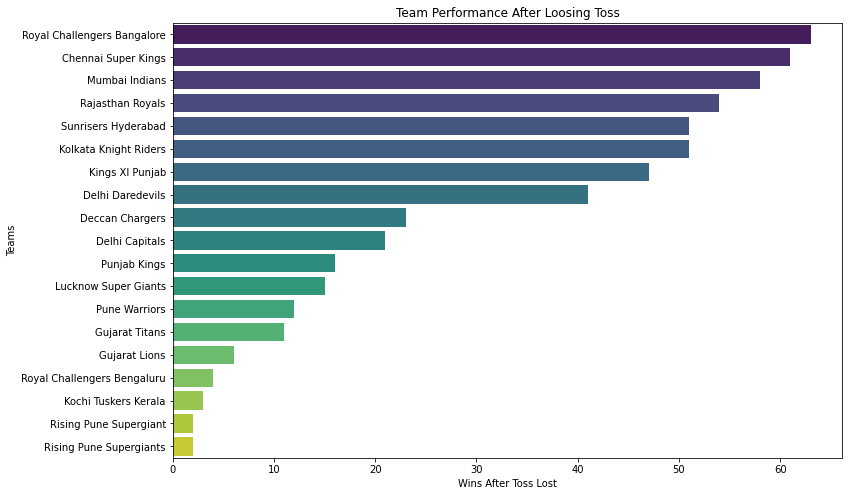

In [0]:
# team performance after lossing toss
query='''
SELECT team1 AS TEAM_NAME,count(winner) AS WINS_AFTER_TOSS_LOST
FROM matches
WHERE toss_winner != winner
GROUP BY TEAM_NAME
ORDER BY WINS_AFTER_TOSS_LOST DESC
'''
toss_won_match_won=spark.sql(query)
toss_won_match_won.show(5)

toss_won_match_won_pd = toss_won_match_won.toPandas()

plt.figure(figsize=(12,8))
sns.barplot(x='WINS_AFTER_TOSS_LOST', y='TEAM_NAME', data=toss_won_match_won_pd ,ci=None,palette='viridis')
plt.xlabel("Wins After Toss Lost")
plt.ylabel("Teams")
plt.title("Team Performance After Loosing Toss")
plt.show()
